# 1. Team 433:  Sapientia Analytica

# 2. Team Members:  
- Tien Le-Dinh
- Ishika Gupta
- Supriya Prasad
- Nikhil Reddy
- Jiayu Zhang

# 3. Executive Summary:  

As of 2022, pizza restaurant is a $47B market, with a 3% CAGR over the last 10 years.  The market is extremely competitive with more than 80,000 pizza restaurants.  New pizza restaurants continue to be opened as the cost of entry into this market is relatively low.  In this competitive environment, it is important for pizza restaurant operators to be up to date with the latest customer preferences so that they can response accordingly to not only defend but also growth their business.  

This analysis will look at Yelp reviews for all pizza restaurants in the US in 2017 and 2018 uncover the root causes of customer satisfaction/dissatisfaction.

# 4. Data Sources:  
Analysis will be performed on customer reviews in the Yelp Dataset. Specifically, we will narrow our data to:
-	Category:contains both Restaurant and Pizza
-	Year: 2017 and 2018
-	State: exclude AB since that is a Canadian state


In [ ]:
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from gensim import corpora
from gensim import models
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
import json

In [ ]:
# Extract list of pizza restaurants from yelp_academic_dataset_business
df = pd.read_json(r'C:\Users\tiend\OneDrive\Documents\ASU MSBA 2024\CIS509 Analytics Unstructured Data\Yelp Dataset Jan 2024\yelp_academic_dataset_business.json', lines=True)
df.dropna(subset=['categories'], inplace=True) # Drop rows in which 'categories' is null
df = df[df['categories'].str.contains('Pizza')] # Filter to keep only business with 'Pizza' in categories
df = df[df['categories'].str.contains('Restaurant')] # From the previous df, filter to keep only business with 'Restaurant' in categories

# Not all restaurants in the list focus on pizza. First, we will grab all the restaurants with
# 'pizz', 'pie', and 'slice' in their name. Restaurants having those words in their name are likely to
# focus on pizza.
pizza_restaurants = df[df['name'].str.contains('pizz|pie|slice', case=False)]
df = df[~df['name'].str.contains('pizz|pie|slice', case=False)] # Drop those restaurants from the original list

# Next, drop business that have more than 3 categories (i.e. more than 1 categories other than Pizza and Restaurant)
# by counting ',' comma. Then add the list to pizza_restaurants created above
df = df[df['categories'].str.count(',') < 3]
pizza_restaurants = pd.concat([pizza_restaurants, df], axis = 0)

In [ ]:
# Load Yelp reviews in chunk of 1M lines each
df = pd.read_json(r'C:\Users\tiend\OneDrive\Documents\ASU MSBA 2024\CIS509 Analytics Unstructured Data\Yelp Dataset Jan 2024\yelp_academic_dataset_review.json',
                  lines = True, chunksize= 1000000)

# Process each chunk and append the relevant data to the pizza_reviews dataframe
counter = 0
for chunk in df:
    chunk['year'] = chunk['date'].dt.year   # Extract year from review date and put in column 'Year'
    chunk = chunk[(chunk['year'] > 2016) & (chunk['year'] < 2019)]    # Only keep 2017 and 2018 year

    # Inner join with pizza_places lookup table to get only the review for pizza places
    join_df = pd.merge(chunk, pizza_restaurants, on='business_id', how='inner')

    # Add to the pizza_reviews data
    if counter == 0: # in the first iteration of the loop, make a deep copy of join_df
        pizza_reviews = join_df.copy(deep=True)
    else: # in subsequent iteration, combine pizza_reviews with join_df
        pizza_reviews = pd.concat([pizza_reviews, join_df], axis = 0)
    counter += 1

In [ ]:
# Export to csv files so that future work can be done without extracting data from big files again
pizza_reviews.to_csv(r'C:\Users\tiend\OneDrive\Documents\ASU MSBA 2024\CIS509 Analytics Unstructured Data\Yelp Dataset Jan 2024\processed data.csv')
pizza_restaurants.to_csv(r'C:\Users\tiend\OneDrive\Documents\ASU MSBA 2024\CIS509 Analytics Unstructured Data\Yelp Dataset Jan 2024\pizza restaurants.csv')

In [ ]:
# Drop columns 'address', 'city', 'postal_code', 'latitude', 'longitude', 'hours'
# from pizza_reviews df as they are not needed for analysis to reduce memory usage and improve performance.
pizza_reviews.drop(['address','city','postal_code','latitude','longitude','hours'], axis=1, inplace=True)

# Add a column to count the total of vote (useful, funny, cool)
pizza_reviews['total_vote'] = pizza_reviews['useful'] + pizza_reviews['funny'] + pizza_reviews['cool']

# 5. Summary Statistics:   

In [ ]:
# Code to tokenize review text and put data in a new 'token' column

# Initialize spacy nlp
nlp = spacy.load("en_core_web_lg")

# Define helper function to lemmatize a word.
def normalize(review, lowercase, remove_stopwords):
    """
    Parameters:
    review (string).  Document to be lemmatized.
    lowercase (boolean).  True: all tokens in document will be changed to lowercase.
    remove_stopwords (boolean):  boolean.  True: stopwords will be removed.

    Returns:
    strings: all lemmatized tokens from the doc separated by a space.

    """
    if lowercase:
        review = review.lower()
    doc = nlp(review)
    lemmatized = list()
    for token in doc:
        if not remove_stopwords or (remove_stopwords and not token.is_stop):
            lemmatized.append(token.lemma_)
    return " ".join(lemmatized)

# Tokenize reviews in 'text' column and put the results in 'token' column
pizza_reviews['token'] = pizza_reviews['text'].apply(normalize, lowercase=True, remove_stopwords=True)

In [ ]:
# Initialize variables to hold various statistics
num_of_comments = 0
unique_word = set() # using the set-type variable since it does not allow duplicates > able to count the number of unique words
num_of_token_per_comment = [] # using the list-type varailbe since we want to measure corpus-level statistics (e.g., avg, max, min, median, etc.)
num_of_token_per_comment_without_stop_words = []
total_number_of_tokens = 0 # in a corpus
unique_reviewer = set() # using the set-type variable since it does not allow duplicates > able to count the number of unique users
date_list = [] # able to measure the number of comments by day, week, etc.

# Loop through each row of the dataframe and calculate the stat:
for index, row in pizza_reviews.iterrows():
    num_of_comments += 1 # each row is a comment

    text = row["text"]
    doc = nlp(text)

    # count the token from review text
    num_of_tokens = len(row['token'])
    total_number_of_tokens += num_of_tokens

    # count token without stop words
    token_count_without_stop_words = 0
    for token in doc:
        if token.is_stop is True:
            pass
        else:
            unique_word.add(str(token).lower())
            token_count_without_stop_words += 1

    # count token and token-without-stop-words per comment
    num_of_token_per_comment.append(num_of_tokens)
    num_of_token_per_comment_without_stop_words.append(token_count_without_stop_words)

    # count unique reviewer
    user_id = row["user_id"]
    unique_reviewer.add(user_id)

    # statistics regarding date
    date = row["date"]
    date_list.append(date)

# Add the num_of_token_per_comment and num_of_token_per_comment_without_stop_words to pizza reviews dataframe
pizza_reviews['tokens count'] = num_of_token_per_comment
pizza_reviews['tokens_without_stop_words count'] = num_of_token_per_comment_without_stop_words

In [ ]:
# statistics
print("number of comments:", num_of_comments)
print("number of unique words:", len(unique_word))
print("total number of words in the corpus:", total_number_of_tokens)
print("average number of words in comments:", np.mean(np.asarray(num_of_token_per_comment)))
print("average number of words in comments without stop words:", np.mean(np.asarray(num_of_token_per_comment_without_stop_words)))
print("maximum number of words in comments:", np.max(np.asarray(num_of_token_per_comment)))
print("maximum number of words in comments without stop words:", np.max(np.asarray(num_of_token_per_comment_without_stop_words)))
print("minimum number of words in comments:", np.min(np.asarray(num_of_token_per_comment)))
print("minimum number of words in comments without stop words:", np.min(np.asarray(num_of_token_per_comment_without_stop_words)))
print("median number of words in comments:", np.median(np.asarray(num_of_token_per_comment)))
print("median number of words in comments without stop words:", np.median(np.asarray(num_of_token_per_comment_without_stop_words)))
print("number of unique reviewers:", len(unique_reviewer))
print('average stars per review:', pizza_reviews['stars_x'].mean())
print('average votes per review:', pizza_reviews['total_vote'].mean())

number of comments: 69001
number of unique words: 46934
total number of words in the corpus: 18522105
average number of words in comments: 268.4324140229852
average number of words in comments without stop words: 51.37470471442443
maximum number of words in comments: 3240
maximum number of words in comments without stop words: 657
minimum number of words in comments: 3
minimum number of words in comments without stop words: 1
median number of words in comments: 196.0
median number of words in comments without stop words: 37.0
number of unique reviewers: 54558
average stars per review: 3.6055274561238244
average votes per review: 1.3622846045709482


In [ ]:
# Number of pizza restaurants by state in the data
print('Number of restaurants covered: ',pizza_restaurants.shape[0])
pd.pivot_table(pizza_restaurants, index='state', values='business_id', aggfunc='count')

Number of restaurants covered:  5433


,business_id
state,
AB,247
AZ,197
CA,76
DE,120
FL,839
ID,117
IL,93
IN,455
LA,211


In [ ]:
# Average star rating by state
pd.pivot_table(pizza_restaurants, index='state', values='stars', aggfunc='mean')

Number of restaurants covered:  5433


,stars
state,
AB,3.352227
AZ,3.197970
CA,3.506579
DE,3.241667
FL,3.314064
ID,3.487179
IL,2.935484
IN,3.202198
LA,3.099526


<function matplotlib.pyplot.show(close=None, block=None)>

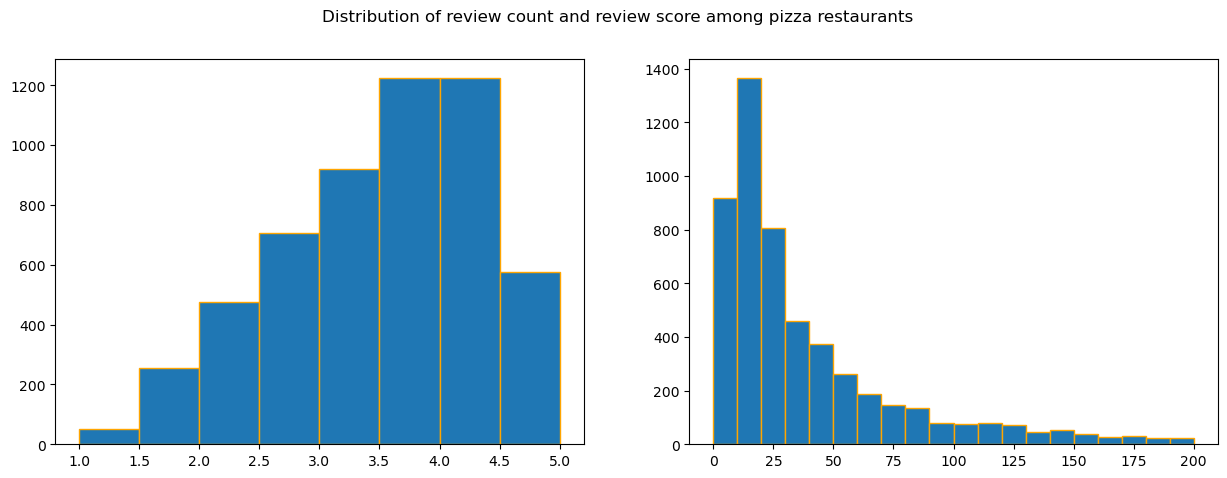

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Distribution of review count and review score among pizza restaurants')
ax1.hist(pizza_restaurants['stars'], bins=[1,1.5,2,2.5,3,3.5,4,4.5,5], edgecolor='orange')
ax2.hist(pizza_restaurants['review_count'], bins=[x*10 for x in range(21)], edgecolor='orange')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

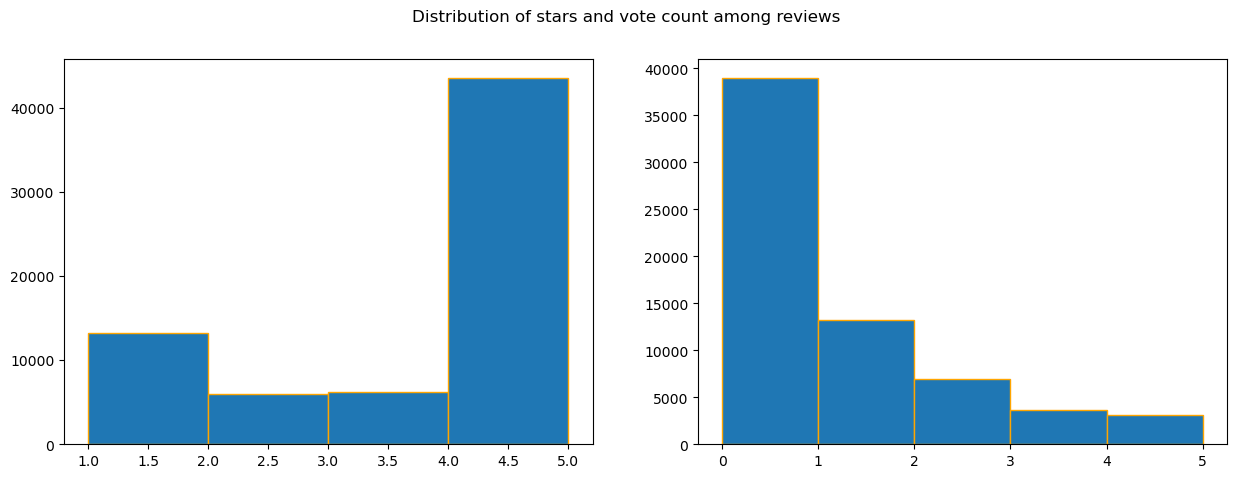

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Distribution of stars and vote count among reviews')
ax1.hist(pizza_reviews['stars_x'], bins=[1,2,3,4,5], edgecolor='orange')
ax2.hist(pizza_reviews['total_vote'], bins=[x for x in range(6)], edgecolor='orange')

plt.show

In [ ]:
# Top 10 pizza restaurants by review count
print('Top 10 pizza restaurants by review count:')
pd.pivot_table(pizza_restaurants, index=['business_id','name','state','stars'], values='review_count').sort_values('review_count', ascending=False).head(10)

Top 10 pizza restaurants by review count:


,,,,review_count
business_id,name,state,stars,
quk6TFDQyuQ4g0KuIb9qUA,Five Points Pizza,TN,4.5,1293.0
Bxmhm659VqrQYHc0hiku5w,Eddie & Sam's NY Pizza,FL,4.5,1182.0
3CFVBCfjdCvESS1ogBv21A,DeSano Pizza Bakery,TN,4.5,992.0
_MWbuRiTqbWEjlfxRAvzWQ,Cristino's Coal Oven Pizza,FL,4.5,936.0
fN12ywQpLXQ93bpwe1N_Ww,Pietro's Coal Oven Pizzeria,PA,3.5,751.0
i5C6RVgr03HSrgCl8oa1Fg,Patxi's Pizza,CA,4.0,730.0
C6KP0hSutumHzLDCFyjvJQ,Katie's Pizza & Pasta Osteria,MO,4.0,723.0
ME7nOO4hHoCwkbssGqsyPA,Blackbird Pizzeria,PA,4.0,716.0
W72rYffSVg0pIaOpRgNniw,Grimaldi's Pizzeria,NV,4.0,689.0


In [ ]:
# Top 10 users by review count and their average star givent
print('Top 10 users by review count and their average star given:')
pd.pivot_table(pizza_reviews, index='user_id', values=['text','stars_y'], aggfunc={'text':'count', 'stars_y':'mean'}).sort_values('text', ascending=False).head(10)

Top 10 users by review count and their average star given:


,stars_y,text
user_id,,
vmUqcqMjlWoBM6qfmUXgyQ,3.532609,46
-G7Zkl1wIWBBmD0KRy_sCw,3.768293,41
gv0coNUFY-fibRwP8IKqPA,3.628205,39
0vg3lFMGU-A9rwTQxL8TJw,3.560000,25
PnwOegp7RXfMeNAyO9fQhQ,3.586957,23
CdCUg3pTo0CivKbD8-Ysdg,3.775000,20
YK32VDCpON7p2iS942JuFw,3.675000,20
0YI3p9o-ntRgRaPWpfa22Q,3.131579,19
zUk_Ww2q1At1QSyRbUjIGQ,3.368421,19


# 6. Data Evaluation  
a. The data covers more than 5000 businesses accross all the states in the original Yelp dataset and  
are more certain to be pizza restaurants so it is suitable for our business questions.  
b. The sample size include 69K reviews from 55k reviewers so it is sufficiently large for us to build our model.  
c. The star rating are dominated by 4, 4.5, and 5 stars. However, we believe that the skewness does not represent bias but  
rather the fact that good restaurants survive better and attracts more customers, hence more reviews.
d. We don't foresee challenges to data processing at this stage.    

# 7. Preliminary Topic Modeling

In [ ]:
# Generate TF-IDF representation
documents = []

# Loop through each reviews and remove all punctuation
for index, row in pizza_reviews.iterrows():
    text = row["text"]
    doc = nlp(text)
    # Remove punctuation
    documents.append(text.replace("!","").replace(".","").replace("?","").replace("[","").replace("]","").replace(")","").replace("(","").replace("  "," ").replace('\"'," ").replace("\'"," ").replace("/"," ").replace("\\"," "))

processed_documents = [] # list for storing tokenized documents

# Tokenize and lemmatize words
for document in documents:
    temp_list = [] # list for storing tokens in a document
    for token in nlp(document):
        if token.is_stop is True: # disregard if token is a stop word
            pass
        elif not nlp.vocab.has_vector(str(token)): # disregard if toek is not in a vocabulary
            pass
        else:
            temp_list.append(str(token.lemma_)) # lemmatize
    processed_documents.append(temp_list)
dictionary = corpora.Dictionary(processed_documents) # index words with integers
corpus = [dictionary.doc2bow(sentence) for sentence in processed_documents] # TF representation
tfidf = models.TfidfModel(corpus) # Fit TF-IDF
corpus_tfidf = tfidf[corpus] # Transform "corpus" into TF-IDF

In [ ]:
# Train LDA model
lda_model = models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=4)

# Coherence measures over different K from 2->15
num_of_topics = []
coherence = []
for k in range(2,16):
    lda_model = models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=k) # train LDA model
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_documents, dictionary=dictionary, coherence='c_v') # calculate coherence measures
    coherence_lda = coherence_model_lda.get_coherence()
    num_of_topics.append(k)
    coherence.append(coherence_lda)

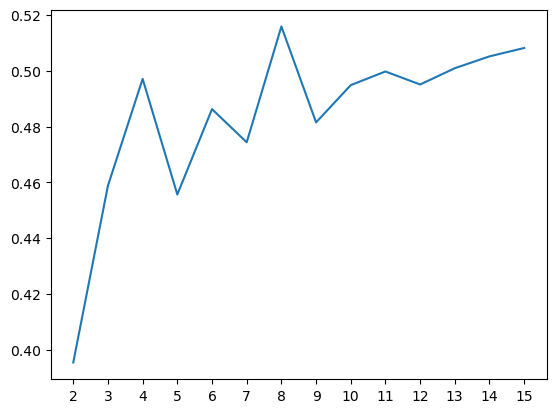

In [ ]:
# Visualizaing coherence measures over different K
plt.plot(num_of_topics, coherence) # x-axis = K, y-axis = coherece measures
plt.xticks(num_of_topics) # To label x-axis with K values
plt.show()

In [ ]:
# Train LDA model with 8 topics.
lda_model = models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=8)

In [ ]:
# Visualize LDA using pyLDAvis
lda_visualization = pyLDAvis.gensim_models.prepare(lda_model, corpus_tfidf, dictionary)
pyLDAvis.display(lda_visualization)

There are too much overlapping.  So, we will try K = 4 where the coherence score is almost as high as K=8 while being more  
likely to have clearer separation between topics.

In [ ]:
# Train LDA model with 4 topics.
lda_model = models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=4)

# Visualize using pyLDAvis
lda_visualization = pyLDAvis.gensim_models.prepare(lda_model, corpus_tfidf, dictionary)
pyLDAvis.display(lda_visualization)

We can see a clear distinction between topic 1 (having good experience) vs topic 2 (having bad experience).  
We can see that customer service is very important as it is mentioned in both topic 1 and topic 2.  
The top salient terms also show that having good fresh pizza (and crust) is important for good customer satisfaction.  
In this, topic 1 and 3 overlaps.  Topic 3 seems to be focused on food.
Topic 4 seems to center around location name which doesn't provide much insight. It might be worthwhile to remove geographic named entity from the text.  


# 8. Proposed Solution

A combination of Topic Modeling and Sentiment Analysis will be used to identify the most relevant and frequent topics (i.e. root cause of satisfaction/dissatisfaction) in customer review.  

Since we have a large dataset, we will try deep learning model to see if it will give better result.
